In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model'

### Dataset
- load data from multi-stocks

In [3]:
from glob import glob

paths = glob("/home/jovyan/graph-stock-pred/Astock/data/pre/*-transformed.csv")
df = pd.DataFrame()
for path in tqdm(paths):
    df = pd.concat([df, pd.read_csv(path)])
df.head()
df.info()

100%|██████████| 16/16 [00:00<00:00, 64.77it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17456 entries, 0 to 1090
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17456 non-null  object 
 1   open           17456 non-null  float64
 2   high           17456 non-null  float64
 3   low            17456 non-null  float64
 4   close          17456 non-null  float64
 5   pre_close      17456 non-null  float64
 6   change         17456 non-null  float64
 7   pct_chg        17456 non-null  float64
 8   ADX            17040 non-null  float64
 9   MACD           16944 non-null  float64
 10  MACDsignal     16944 non-null  float64
 11  MACDhist       16944 non-null  float64
 12  RSI            17248 non-null  float64
 13  ATR            17248 non-null  float64
 14  OBV            17456 non-null  float64
 15  BETA           17392 non-null  float64
 16  upperBAND      17408 non-null  float64
 17  middleBAND     17408 non-null  float64
 18  lowerBA

- split train, val, test, ood datasets by date


In [4]:
# train: 2018.07 - 2020.06
df_train = df[df["date"]<"2020-07-01"].reset_index(drop=True)
# val: 2020.07 - 2020.12
df_val = df[(df["date"]>="2020-07-01") & (df["date"]<"2021-01-01")].reset_index(drop=True)
# test: 2021.01 - 2021.06
df_test = df[(df["date"]>="2021-01-01") & (df["date"]<"2021-07-01")].reset_index(drop=True)
# ood: 2021.07 - 2022.06
df_ood = df[(df["date"]>="2021-07-01") & (df["date"]<"2022-07-01")].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)

(9632, 33) (2064, 33) (1840, 33) (3920, 33)


- compute `label` column from `pct_chg` 
    - Thesis uses: $(close - pre close) / close$, but stock price change should devide by previous price. We corrected here
- We uese `qcut` and the distribution of `pct_chg` between 2018/07/02 - 2022/06/30 is: 
    ```
        (-0.0686, -0.00503]    325
        (0.0069, 0.0997]       325
        (-0.00503, 0.0069]     324
    ```
- Then filter out days with no news

In [5]:
def gen_label(df):
    df["label"] = pd.qcut(df['pct_chg'], q=3, labels=[0,1,2])
    return df


df_train = gen_label(df=df_train)
df_val = gen_label(df=df_val)
df_test = gen_label(df=df_test)
df_ood = gen_label(df=df_ood)

df_train = df_train[df_train.titles.notnull()].reset_index(drop=True)
df_val = df_val[df_val.titles.notnull()].reset_index(drop=True)
df_test = df_test[df_test.titles.notnull()].reset_index(drop=True)
df_ood = df_ood[df_ood.titles.notnull()].reset_index(drop=True)


In [6]:
df_train[["pct_chg","label"]].describe(), df_val[["pct_chg","label"]].describe(), df_test[["pct_chg","label"]].describe(), df_ood[["pct_chg","label"]].describe()

(           pct_chg
 count  1135.000000
 mean     -0.000433
 std       0.018362
 min      -0.100000
 25%      -0.008789
 50%       0.000000
 75%       0.007826
 max       0.099644,
            pct_chg
 count  1159.000000
 mean      0.006107
 std       0.029719
 min      -0.098237
 25%      -0.009409
 50%       0.001965
 75%       0.015467
 max       0.100000,
            pct_chg
 count  1155.000000
 mean      0.004295
 std       0.038274
 min      -0.100000
 25%      -0.014962
 50%       0.001931
 75%       0.021312
 max       0.154421,
            pct_chg
 count  2382.000000
 mean      0.000628
 std       0.027163
 min      -0.100000
 25%      -0.012943
 50%       0.000000
 75%       0.012434
 max       0.100000)

- compute verb-A0-A1 triplets number as `AV_num`

In [7]:
df_train["AV_num"] = df_train["verbA0A1"].apply(lambda x: len(eval(x)))
df_val["AV_num"] = df_val["verbA0A1"].apply(lambda x: len(eval(x)))
df_test["AV_num"] = df_test["verbA0A1"].apply(lambda x: len(eval(x)))
df_ood["AV_num"] = df_ood["verbA0A1"].apply(lambda x: len(eval(x)))

- merge `stock_factors` to array in one column

Now each sample will have these factors: 
```
    ADX                                                11.493372
    MACD                                               -1.556851
    MACDsignal                                         -1.221986
    MACDhist                                           -0.334864
    RSI                                                44.103107
    ATR                                                 3.732317
    OBV                                              -71157437.0
    BETA                                                1.032639
    upperBAND                                         195.743838
    middleBAND                                        193.008206
    lowerBAND                                         190.272574
    成交股數                                              28663220.0
    成交筆數                                                  7758.0
    成交金額                                            6173115899.0
    殖利率(%)                                                  3.73
    本益比                                                    16.12
    股價淨值比                                                   3.46
```

In [8]:
# remove nan rows
factor_cols = ["ADX","MACD","MACDsignal","MACDhist","RSI","ATR","OBV","BETA","upperBAND","middleBAND","lowerBAND","成交股數","成交筆數","成交金額","殖利率(%)","本益比","股價淨值比"]
for col in tqdm(factor_cols):
    df_train = df_train[df_train[col].notnull()].reset_index(drop=True)
    df_val = df_val[df_val[col].notnull()].reset_index(drop=True)
    df_test = df_test[df_test[col].notnull()].reset_index(drop=True)
    df_ood = df_ood[df_ood[col].notnull()].reset_index(drop=True)


# Normalization all factors to the same scale
standard_scaler = StandardScaler()
# 1. fit from training set
standard_scaler.fit(df_train[factor_cols])
# 2. transform train, val, test, ood sets, since stock factors are used in training feature, if we don't know future price, we can't normalize it with the future time duration
df_train[factor_cols] = standard_scaler.transform(df_train[factor_cols])
df_val[factor_cols] = standard_scaler.transform(df_val[factor_cols])
df_test[factor_cols] = standard_scaler.transform(df_test[factor_cols])
df_ood[factor_cols] = standard_scaler.transform(df_ood[factor_cols])

100%|██████████| 17/17 [00:00<00:00, 310.33it/s]


In [9]:
# disbutions of stock factors have huge difference between train, val, test, odd sets
df_ood[factor_cols].describe()

,ADX,MACD,MACDsignal,MACDhist,RSI,ATR,OBV,BETA,upperBAND,middleBAND,lowerBAND,成交股數,成交筆數,成交金額,殖利率(%),本益比,股價淨值比
count,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,-0.224566,-0.179928,-0.162805,-0.097736,-0.085460,0.373567,10.100106,-0.052804,0.142120,0.137354,0.132289,2.074304,3.079792,0.532674,-0.788585,0.786663,0.254671
std,0.901323,1.259878,1.265308,1.448785,0.932436,1.505520,8.844921,0.305883,1.628572,1.633433,1.638501,3.578315,4.676668,2.013605,1.388188,5.622073,1.385106
min,-1.697927,-7.419360,-6.685767,-10.837002,-2.624378,-0.670767,-1.494741,-2.443393,-0.666948,-0.666790,-0.666433,-1.051414,-0.998497,-0.591288,-2.165998,-0.795205,-0.968933
25%,-0.877128,-0.297096,-0.301057,-0.226863,-0.712831,-0.506604,1.273468,-0.228140,-0.595402,-0.596788,-0.599223,-0.036221,0.305697,-0.453377,-1.516693,-0.578210,-0.685732
50%,-0.408114,-0.123382,-0.120167,-0.030836,-0.128789,-0.244172,11.462266,-0.056618,-0.487729,-0.490896,-0.495432,0.966124,1.669024,-0.176882,-1.026108,-0.291069,-0.170822
75%,0.274850,0.037324,0.042059,0.130424,0.469815,0.187915,16.129859,0.121716,-0.196896,-0.201437,-0.210419,2.760471,4.021294,0.726999,-0.232514,0.093369,0.408453
max,3.763879,8.539062,8.058931,7.032714,3.307178,5.936541,31.007104,1.496315,5.475820,5.445961,5.438982,35.390248,44.502171,24.852712,9.521477,42.358232,6.271999


In [10]:
# 3. merge it to one column
def merge_factors(df):
    factor_values = df[factor_cols].values
    df["stock_factors"] = 0
    for i in tqdm(range(df.shape[0])):
        df.loc[i, "stock_factors"] = str(factor_values[i].tolist())
    df = df.drop(factor_cols, axis=1)
    return df

df_train = merge_factors(df=df_train)
df_val = merge_factors(df=df_val)
df_test = merge_factors(df=df_test)
df_ood = merge_factors(df=df_ood)
df_train["stock_factors"]

100%|██████████| 2187/2187 [00:00<00:00, 13667.15it/s]


0      [-0.9670314108827222, -0.12977926654466732, -0...
1      [-0.9234451970901715, -0.12683007558276685, -0...
2      [-1.1045382914006334, -0.12654209715900977, -0...
3      [-0.9957760745471698, -0.12399888069961544, -0...
4      [1.0882565672236812, -0.10628363820339623, -0....
                             ...                        
945    [-0.4101751203777202, -0.06391346769156044, -0...
946    [-0.48406508380916585, -0.07169057871399129, -...
947    [-0.7293958846360331, -0.08486615066879878, -0...
948    [-0.8325296013758262, -0.09092849857962162, -0...
949    [-0.8412497351875696, -0.112144034231991, -0.0...
Name: stock_factors, Length: 950, dtype: object

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           950 non-null    object  
 1   open           950 non-null    float64 
 2   high           950 non-null    float64 
 3   low            950 non-null    float64 
 4   close          950 non-null    float64 
 5   pre_close      950 non-null    float64 
 6   change         950 non-null    float64 
 7   pct_chg        950 non-null    float64 
 8   affected_date  950 non-null    object  
 9   news_count     950 non-null    float64 
 10  titles         950 non-null    object  
 11  verbA0A1       950 non-null    object  
 12  verb           950 non-null    object  
 13  A0             950 non-null    object  
 14  A1             950 non-null    object  
 15  stock_id       950 non-null    int64   
 16  label          950 non-null    category
 17  AV_num         950 non-null    int6

## Generating the masks of verb, A0, A1

In [12]:
max_len = 512

def string_to_tuples_list(text):
    if text is np.nan or text =='[]':
        return []
    text = ''.join(text.split('], ['))
    tmp = eval(text.strip('[').strip(']'))
    if not isinstance(tmp[0],tuple):
        return [tmp]
    return list(tmp)

def mask(df):
    df = df.reset_index(drop = True)
    df['verb_mask'] = 0
    df['A0_mask'] = 0
    df['A1_mask'] = 0
    df['verb_mask'] = df['verb_mask'].astype('object')
    df['A0_mask'] = df['A0_mask'].astype('object')
    df['A1_mask'] = df['A1_mask'].astype('object')
    for index,row in tqdm(df.iterrows()):

        df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
        AV_num = 0
        for k,col in enumerate(['verb','A0','A1']):
            masks = []
            for j in range(len(row['verbA0A1'])):
                mask = np.zeros(max_len - 1)
                idx = []
                for v in row['verbA0A1'][j][k]:
                    idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
                counter = Counter(idx)

                mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
                mask.insert(0,0)
                masks.append(mask)
            AV_num = len(masks)
            for i in range(10 - len(masks)):
                masks.append(np.zeros(max_len))
            while len(masks)>10:
                masks.pop()
            name = col+'_mask'
            df.at[index,name] = np.array(masks)
        if AV_num>10:
            AV_num=10
        df.loc[index,'AV_num'] = int(AV_num)
    df.AV_num = df.AV_num.astype('int')
    df.stock_factors = df.stock_factors.apply(np.array)
    return df

In [13]:
df_train = df_train[df_train["AV_num"] > 0].reset_index(drop=True)
df_val = df_val[df_val["AV_num"] > 0].reset_index(drop=True)
df_test = df_test[df_test["AV_num"] > 0].reset_index(drop=True)
df_ood = df_ood[df_ood["AV_num"] > 0].reset_index(drop=True)


for col in ['verb','A0','A1']:
    df_train[col] = df_train[col].apply(string_to_tuples_list)
    df_val[col] = df_val[col].apply(string_to_tuples_list)
    df_test[col] = df_test[col].apply(string_to_tuples_list)
    df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
    df_train[col] = df_train[col].apply(ast.literal_eval)
    df_val[col] = df_val[col].apply(ast.literal_eval)
    df_test[col] = df_test[col].apply(ast.literal_eval)
    df_ood[col] = df_ood[col].apply(ast.literal_eval)


df_train = mask(df=df_train)
df_val = mask(df=df_val)
df_test = mask(df=df_test)
df_ood = mask(df=df_ood)

df_train.info()
df_val.info()
df_test.info()
df_ood.info()

759it [00:00, 786.89it/s]
632it [00:02, 271.47it/s]
889it [00:02, 304.36it/s]
1938it [00:05, 352.96it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           759 non-null    object  
 1   open           759 non-null    float64 
 2   high           759 non-null    float64 
 3   low            759 non-null    float64 
 4   close          759 non-null    float64 
 5   pre_close      759 non-null    float64 
 6   change         759 non-null    float64 
 7   pct_chg        759 non-null    float64 
 8   affected_date  759 non-null    object  
 9   news_count     759 non-null    float64 
 10  titles         759 non-null    object  
 11  verbA0A1       759 non-null    object  
 12  verb           759 non-null    object  
 13  A0             759 non-null    object  
 14  A1             759 non-null    object  
 15  stock_id       759 non-null    int64   
 16  label          759 non-null    category
 17  AV_num         759 non-null    int6

In [14]:
# df_train["titles"].apply(lambda x: len(x)).value_counts().sort_index()
df_train["verbA0A1"][100]

[[[(37, 1)], [(33, 4)], [(38, 4)]],
 [[(57, 2)], [(43, 14)], [(59, 9)]],
 [[(103, 2)], [(100, 3)], [(105, 15)]],
 [[(155, 2)], [(121, 34)], [(157, 9)]],
 [[(181, 2)], [(167, 14)], [(183, 23)]],
 [[(222, 2)], [(208, 14)], [(224, 9)]]]

## Create Dataloader

In [15]:
BATCH_SIZE = 16
class_names = ['negative', 'neutral', 'positive']
class GPReviewDataset(Dataset):
    def __init__(self, titles, targets, verb, A0, A1, AV_num, tokenizer, stock_factors, max_len):
        self.titles = titles
        self.targets = targets
        self.stock_factors = stock_factors
        self.verb = verb
        self.A0 = A0
        self.A1 = A1
        self.AV_num = AV_num
        self.tokenizer = tokenizer
        self.max_len = max_len
      
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, item):
        titles = str(self.titles[item])
        target = self.targets[item]
        stock_factors = self.stock_factors[item]
        v = self.verb[item]
        a0 = self.A0[item]
        a1 = self.A1[item]
        av_num = self.AV_num[item]

        encoding = self.tokenizer.encode_plus(
            titles,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'titles': titles,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'stock_factors':torch.tensor(stock_factors),
            'verb': torch.tensor(v),
            'A0': torch.tensor(a0),
            'A1': torch.tensor(a1),
            'AV_num': torch.tensor(av_num)
        }

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        titles=df.titles.to_numpy(),
        targets=df.label.to_numpy(),
        stock_factors = df.stock_factors,
        verb = df.verb_mask,
        A0 = df.A0_mask,
        A1 = df.A1_mask,
        AV_num = df.AV_num,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

In [17]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [18]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['titles', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [19]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
        self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304, nhead=1).to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2).to(device)
        self.drop = nn.Dropout(p=0.1).to(device)
        self.out1 = nn.Linear((self.bert.config.hidden_size*3)*10, (self.bert.config.hidden_size*3)*3).to(device)
        self.out = nn.Linear((self.bert.config.hidden_size*3)*3, n_classes).to(device)
        self.avgpool = nn.AvgPool2d((3,2), stride=2).to(device)
        self.flatten2 = nn.Flatten(2,-1).to(device)
        self.flatten = nn.Flatten(1,-1).to(device)
        self.sig = nn.Sigmoid().to(device)
        self.relu = nn.ReLU().to(device)
        self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size).to(device)
    
    def forward(self, input_ids, attention_mask, verb, A0, A1, AV_num):
        # get bert embedding 
        hidden_state = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0].to(device)
        batch = hidden_state.shape[0]
        verb_tmp = verb.clone().to(device)

        # mask verb
        AV_idx = []
        for idx, num in enumerate(AV_num):
            self_label = torch.randint(0,num,(1,))[0].to(device)
            AV_idx.append(self_label)
            verb_tmp[idx,self_label,:]=0

        # verb label
        AV_idx = torch.tensor(AV_idx).to(device)

        V_mask = torch.unsqueeze(verb,3).to(device)
        V_mask = torch.cat(768 * [V_mask],3).to(device)
        V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        K = self.Key(torch.squeeze(V_mask.float())).to(device)
        
        # get verb embedding after masking(8*10*1*768)
        V_mask_mask = torch.unsqueeze(verb_tmp,3).to(device)
        V_mask_mask = torch.cat(768 * [V_mask_mask],3).to(device)
        transformer_input = torch.mean(V_mask_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)

        # get A0 embedding(8*10*2*768)
        A0_mask = torch.unsqueeze(A0,3).to(device)
        A0_mask = torch.cat(768 * [A0_mask],3).to(device)
        A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A0_mask],2).to(device)

        # get A1 embedding(8*10*3*768)
        A1_mask = torch.unsqueeze(A1,3).to(device)
        A1_mask = torch.cat(768 * [A1_mask],3).to(device)
        A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A1_mask],2).to(device)

        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # turn to (10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])

        # get transformer output(10*8*2304)
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # turn to (8*10*2304)
        self_pred = torch.zeros((batch,10)).to(device)
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        # Q For CL
        for idx,i in enumerate(AV_idx):
            Q = torch.unsqueeze(self.Querry(transformer_output[idx,i,:768]),0).to(device)
            self_pred[idx]=(Q @ K[idx].T).to(device)

        # get transformer input for classification(8*10*3*768)
        transformer_input = torch.cat([V_mask,A0_mask,A1_mask],2).to(device)
        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # get transformer output(10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # handle exception
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        output = self.flatten(transformer_output.float()).to(device)
        output = self.sig(output).to(device)
        output = self.out1(output).to(device)
        output = self.sig(output).to(device)
        output = self.drop(output).to(device)
        output = self.out(output).to(device)

        return output,self_pred,AV_idx


In [20]:
model = SentimentClassifier(n_classes=3)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)


Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


In [21]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
verbs = data['verb'].to(device)
A0s = data['A0'].to(device)
A1s = data['A1'].to(device)
AV_num = data['AV_num'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


In [22]:
F.softmax(model(input_ids, attention_mask, verb=verbs, A0=A0s, A1=A1s, AV_num=AV_num)[0], dim=1)

tensor([[0.2512, 0.4605, 0.2883],
        [0.2261, 0.5447, 0.2291],
        [0.2361, 0.5328, 0.2311],
        [0.2373, 0.4178, 0.3448],
        [0.2465, 0.4637, 0.2897],
        [0.2221, 0.5508, 0.2270],
        [0.2327, 0.5360, 0.2314],
        [0.2362, 0.4211, 0.3426],
        [0.2454, 0.4637, 0.2909],
        [0.2209, 0.5509, 0.2282],
        [0.2269, 0.5435, 0.2296],
        [0.2371, 0.4213, 0.3416],
        [0.2447, 0.4642, 0.2911],
        [0.2223, 0.5461, 0.2315],
        [0.2303, 0.5410, 0.2287],
        [0.2408, 0.4179, 0.3413]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [24]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    correct_predictions_verbs = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        verb = d["verb"].to(device)
        A0 = d["A0"].to(device)
        A1 = d["A1"].to(device)
        AV_num = d["AV_num"].to(device)

        outputs,self_outputs,self_labels = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            verb = verb,
            A0 = A0,
            A1 = A1,
            AV_num = AV_num
        )
        self_outputs = self_outputs.to(device)
        self_labels = self_labels.to(device)

        if outputs.dim()==1:
            outputs = torch.unsqueeze(outputs,0)
        _, preds = torch.max(outputs, dim=1)
        _, self_preds = torch.max(self_outputs, dim=1)
        
        # print(targets.shape,outputs.shape)
        loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

        correct_predictions += torch.sum(preds == targets)
        correct_predictions_verbs += torch.sum(self_preds == self_labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses), correct_predictions_verbs.double()/n_examples

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            verb = d["verb"].to(device)
            A0 = d["A0"].to(device)
            A1 = d["A1"].to(device)
            AV_num = d["AV_num"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                verb = verb,
                A0 = A0,
                A1 = A1,
                AV_num = AV_num
            )[0]
            
            if outputs.dim()==1:
                outputs = torch.unsqueeze(outputs,0)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
history = defaultdict(list)
best_accuracy = 0

In [27]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy {cl_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBert_SRL(FC)_CL(V).bin')
    best_accuracy = val_acc


Epoch 1/10
----------
Train loss 1.3336263348658879 accuracy 0.3544137022397892 cl_accuracy 0.6824769433465085
Val   loss 1.3998125791549683 accuracy 0.3022151898734177

Epoch 2/10
----------
Train loss 1.1665309915939968 accuracy 0.310935441370224 cl_accuracy 0.7127799736495389
Val   loss 1.1240767747163773 accuracy 0.32436708860759494

Epoch 3/10
----------
Train loss 1.0519268525143464 accuracy 0.3451910408432148 cl_accuracy 0.7088274044795784
Val   loss 1.1110308200120926 accuracy 0.3022151898734177

Epoch 4/10
----------
Train loss 1.0220201089978218 accuracy 0.3346508563899868 cl_accuracy 0.7009222661396575
Val   loss 1.0983453586697578 accuracy 0.37658227848101267

Epoch 5/10
----------
Train loss 0.9904542292157809 accuracy 0.3596837944664032 cl_accuracy 0.689064558629776
Val   loss 1.1296247273683548 accuracy 0.2927215189873418

Epoch 6/10
----------
Train loss 0.9895736190179983 accuracy 0.3702239789196311 cl_accuracy 0.7009222661396575
Val   loss 1.1190432786941529 accuracy 

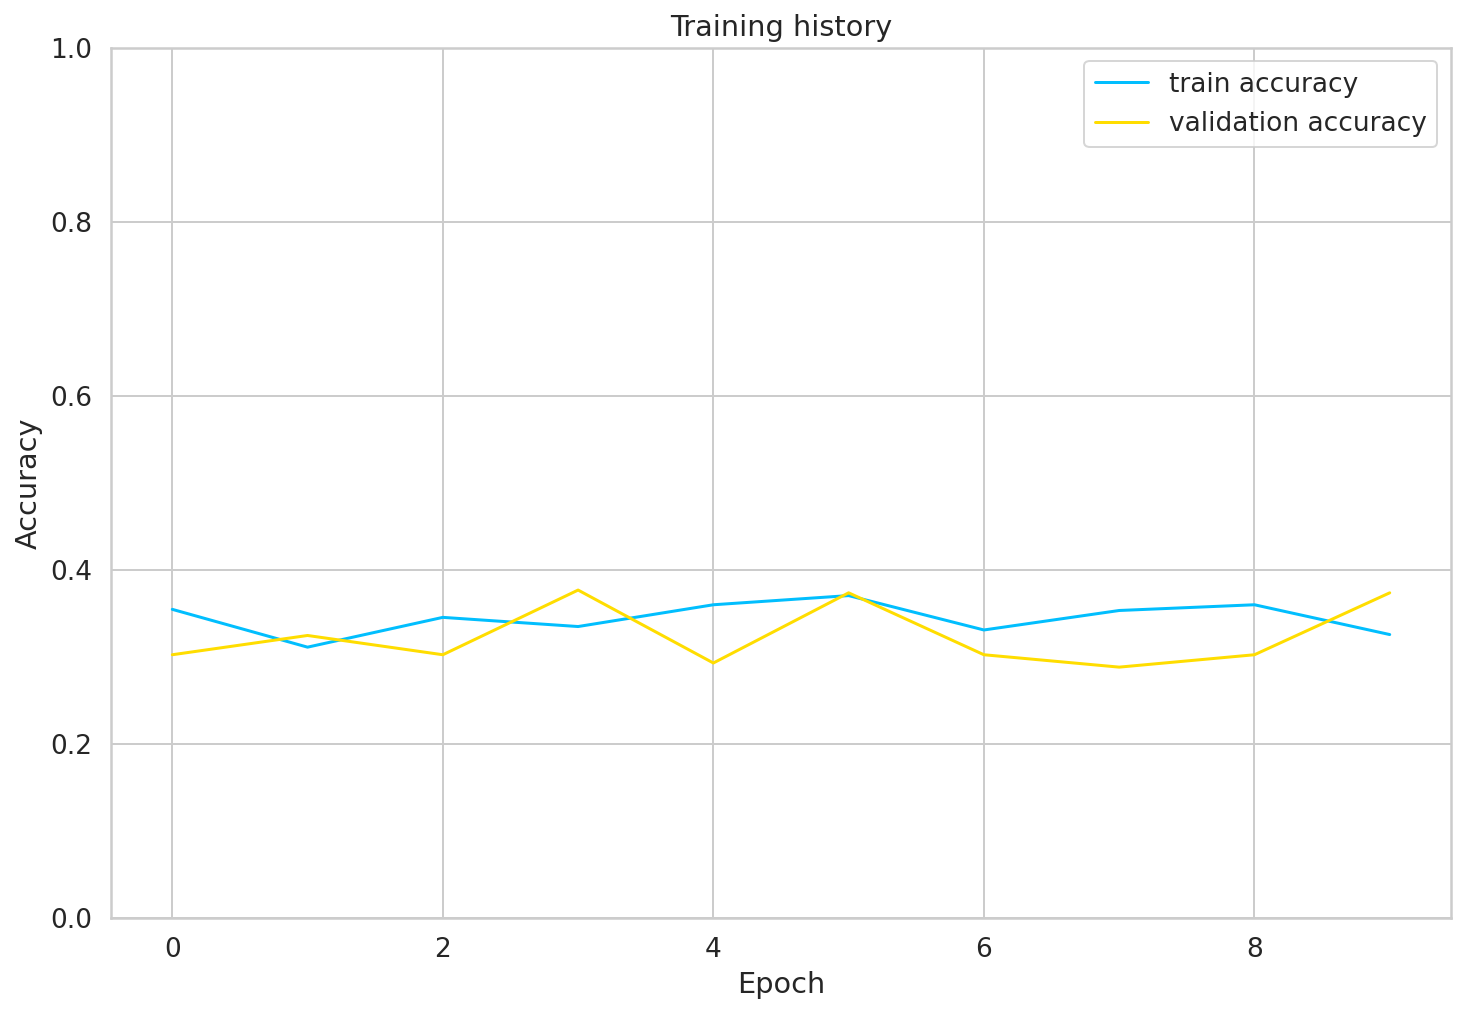

In [28]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [22]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)
model.load_state_dict(torch.load('Pretrained_RoBert_SRL(FC)_CL(V).bin'))

Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


<All keys matched successfully>

In [61]:
len(df_test)

889

In [25]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.3880764904386952

In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["titles"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )[0]
#       _, preds = torch.max(outputs, dim=1)
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [27]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative     0.4000    0.0707    0.1202       311
     neutral     0.0000    0.0000    0.0000       235
    positive     0.3873    0.9417    0.5489       343

    accuracy                         0.3881       889
   macro avg     0.2624    0.3375    0.2230       889
weighted avg     0.2894    0.3881    0.2538       889



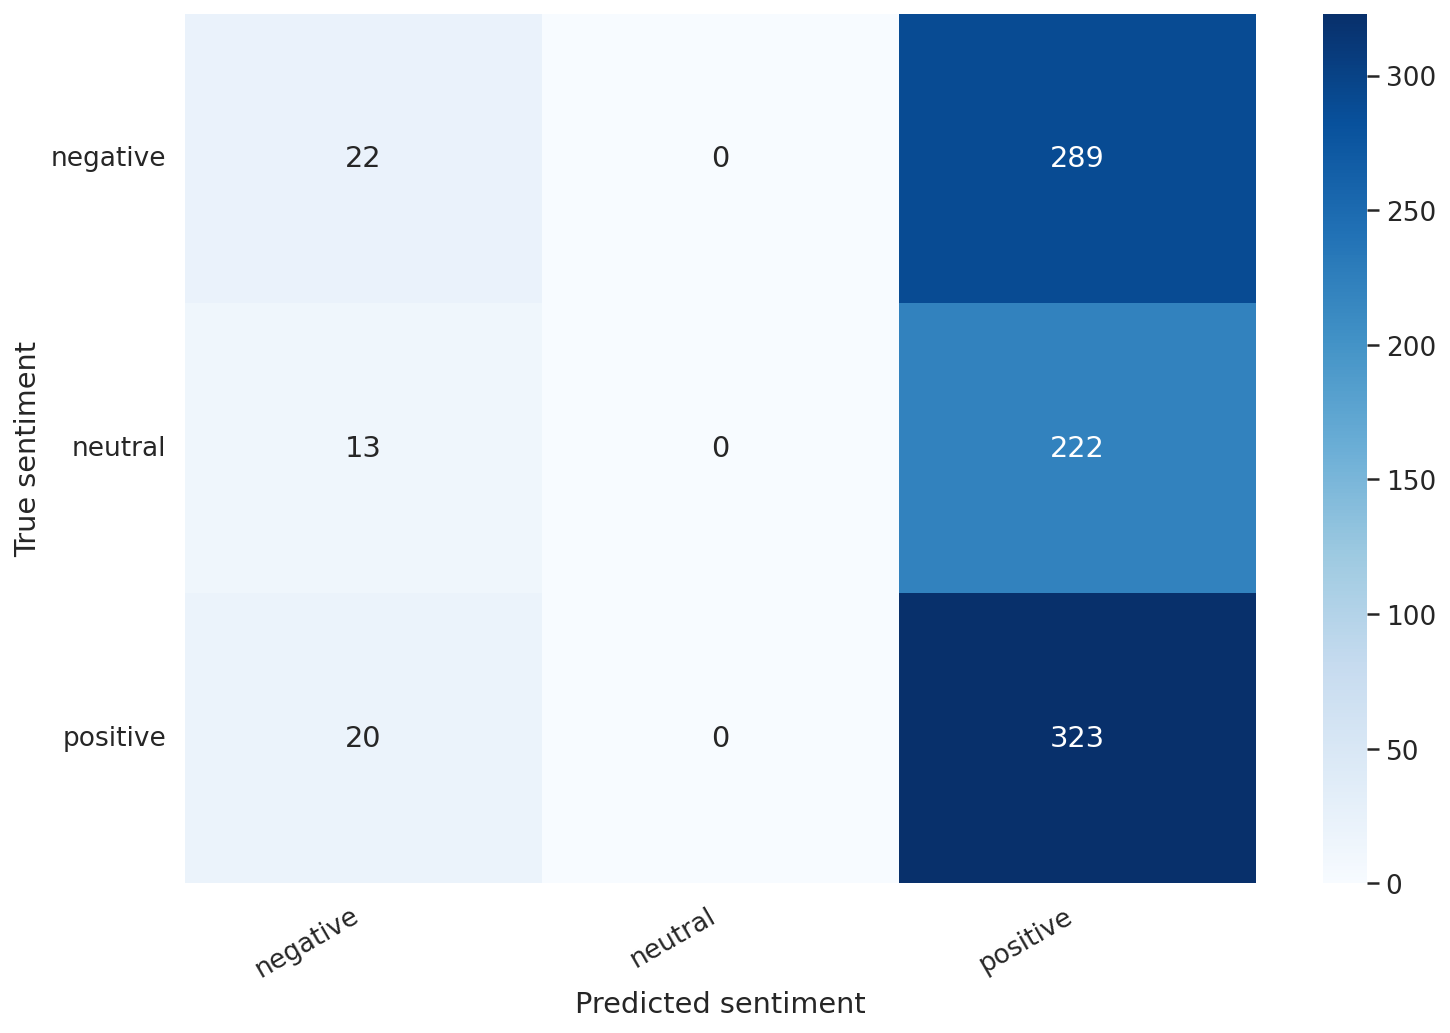

In [28]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/conda_env/bert_try/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative     0.2895    0.0169    0.0320       650
     neutral     0.0000    0.0000    0.0000       609
    positive     0.3521    0.9853    0.5188       679

    accuracy                         0.3509      1938
   macro avg     0.2139    0.3341    0.1836      1938
weighted avg     0.2205    0.3509    0.1925      1938



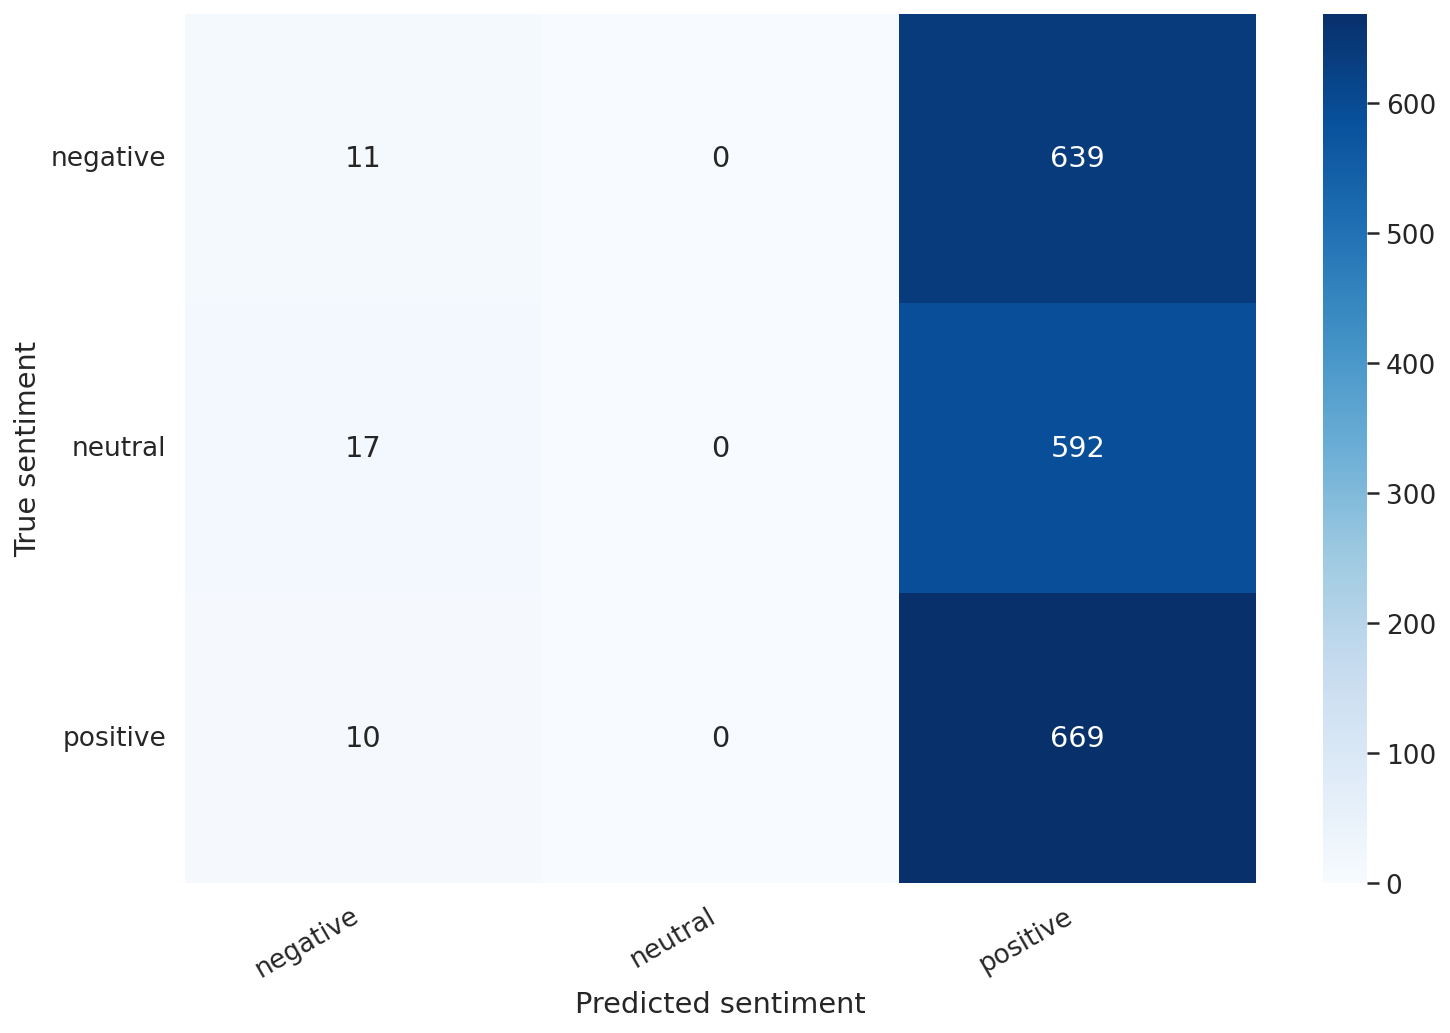

In [29]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [69]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0: 'text',1: 'prediction',2: 'probability',3: 'labels'})
df.to_csv('try_Pretrained_RoBert_SRL(FC)_V_ood.csv',sep='\t')